In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
valid_len = torch.tensor([2, 3])
print(valid_len.shape)
print(valid_len[:, None])
torch.arange((10), dtype=torch.float32)[None, :] < valid_len[:,None]

torch.Size([2])
tensor([[2],
        [3]])


tensor([[ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False]])

In [3]:
def masked_softmax(X, valid_lens):
    def _sequence_mask(X, valid_len, value=0):
        mask = torch.arange(X.shape[-1]) < valid_len.view(-1, 1)
        X[~mask] = value
        return X

    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.view(-1)
        X = _sequence_mask(X.view(-1, shape[-1]), valid_lens, value=-1e6)
        return F.softmax(X.view(shape), dim=-1)


# torch.randn(2, 3).size(2)
# _sequence_mask(torch.randn(2, 3), torch.tensor([1, 2]))

In [4]:
masked_softmax(torch.randn(2,2,4), torch.tensor([2,3]))

tensor([[[0.8649, 0.1351, 0.0000, 0.0000],
         [0.7760, 0.2240, 0.0000, 0.0000]],

        [[0.0567, 0.7183, 0.2250, 0.0000],
         [0.3782, 0.3354, 0.2863, 0.0000]]])

In [5]:
Q = torch.ones(2,3,4)
K = torch.ones(2,4,6)
(Q@K).shape

torch.Size([2, 3, 6])

$\mathcal{Attention} = \mathcal{softmax}(\frac{QK^T}{\sqrt{d}})V$

In [6]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout=0.0) -> None:
        super().__init__()
        self.dropout = dropout

    def forward(self, queries, keys, values, valid_len=None):
        d = queries.shape[-1]
        scores = queries@keys.transpose(1,2) / d**0.5
        self.attn_weights = masked_softmax(scores, valid_len)
        print(self.attn_weights)
        return self.attn_weights@values


In [7]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attn = DotProductAttention(dropout=0.5)
attn.eval()
attn(queries, keys, values, valid_lens)

tensor([[[0.4057, 0.5943, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0958, 0.1081, 0.3159, 0.2771, 0.1308, 0.0722, 0.0000, 0.0000,
          0.0000, 0.0000]]])


tensor([[[ 0.3561, -0.4920,  0.7572,  1.2899]],

        [[-0.1992,  0.0247,  0.1734, -0.4909]]])

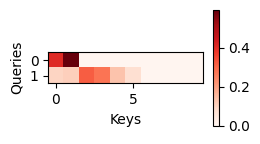

In [9]:
from d2l_common import show_heatmaps

show_heatmaps(attn.attn_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [ ]:
class AdaptiveAttention(nn.Module):
    